In [105]:
import pandas as pd
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import OneHotEncoder
from tensorflow.keras.layers import Dense
from tensorflow.keras.models import Sequential
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_absolute_error
from sklearn.ensemble import RandomForestRegressor

In [192]:
#save dateset into the cleaned folder
df_acled = pd.read_csv('datasets/preprocessed/df_acled.csv')

# save this dataset into the cleaned folder
df_lga = pd.read_csv('datasets/preprocessed/df_lga.csv')

# save dataset as a new csv file
df_gtd = pd.read_csv('datasets/preprocessed/df_gtd.csv')

# save this dataset into the cleaned folder
df_lga_features = pd.read_csv('datasets/preprocessed/df_lga_features.csv')

In [193]:
# merge the ACLED dataset with the LGA features
df_acled = df_acled.rename(columns={'admin2': 'lga_name'}) # rename the admin2 to lga_name in acled
df_lga_features = df_lga_features.rename(columns={'Lga Name': 'lga_name'}) # rename the Lga Name to lga_name in LGA features dataset
df_acled_lga = pd.merge(df_acled, df_lga_features, on='lga_name')

df_acled_lga

,event_id_cnty,event_date,year,time_precision,disorder_type,event_type,sub_event_type,actor1,inter1,actor2,...,Has Forest,Has Mountain,Has ocean,Has valley,Has desert,Has rock,Has plateau,Has creeks,Has none,Major Occupation
0,NIG30571,2023-03-24,2023,1,Demonstrations,Protests,Peaceful protest,Protesters (Nigeria),6,unknown,...,0,0,0,0,0,0,0,0,0,agriculture
1,NIG30686,2023-03-23,2023,1,Political violence,Violence against civilians,Abduction/forced disappearance,Fulani Ethnic Militia (Nigeria),4,Civilians (Nigeria),...,0,0,0,0,0,0,0,0,0,agriculture
2,NIG30637,2023-03-22,2023,1,Political violence,Violence against civilians,Attack,Fulani Ethnic Militia (Nigeria),4,Civilians (Nigeria),...,0,0,0,0,0,0,0,0,0,agriculture
3,NIG29466,2023-01-04,2023,1,Political violence,Battles,Armed clash,Hausa Ethnic Militia (Nigeria),4,Fulani Ethnic Militia (Nigeria),...,0,0,0,0,0,0,0,0,0,agriculture
4,NIG29455,2023-01-03,2023,1,Political violence,Battles,Armed clash,Hausa Ethnic Militia (Nigeria),4,Fulani Ethnic Militia (Nigeria),...,0,0,0,0,0,0,0,0,0,agriculture
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
23401,NIG5432,2014-01-26,2014,1,Political violence,Battles,Armed clash,Police Forces of Nigeria (1999-2015),1,Unidentified Armed Group (Nigeria),...,0,0,0,0,0,0,0,0,1,farming
23402,NIG5353,2014-01-07,2014,1,Political violence,Violence against civilians,Attack,Unidentified Armed Group (Nigeria),3,Civilians (Nigeria),...,0,1,0,0,0,0,0,0,0,farming
23403,NIG4348,2013-01-31,2013,1,Political violence,Battles,Armed clash,Police Forces of Nigeria (1999-2015),1,Unidentified Armed Group (Nigeria),...,0,0,0,0,0,0,0,0,0,farming
23404,NIG3842,2012-08-10,2012,1,Political violence,Battles,Armed clash,Police Forces of Nigeria (1999-2015),1,Boko Haram - Jamaatu Ahli is-Sunnah lid-Dawati...,...,0,0,0,0,0,0,0,0,0,farming


In [194]:
drop_cols = ['event_id_cnty', 'event_date', 'actor2', 'location', 'source', 'source_scale', 'notes', 'lga_name', ]
df_acled_lga.drop(drop_cols, axis=1, inplace=True)

In [195]:
df_acled_lga = df_acled_lga.iloc[:, 14:]

In [196]:
# Percentage of null values in fields containing nulls
null_pct = df_acled_lga.isnull().mean() * 100
null_pct = null_pct[null_pct.values > 0]

for column in null_pct.index:
    if df_acled_lga[column].dtype in ['float64', 'int64']:
        df_acled_lga[column].fillna(df_acled_lga[column].mean(), inplace=True)
    else:
        df_acled_lga[column].fillna(df_acled_lga[column].mode().iloc[0], inplace=True)

In [197]:
# Identify categorical columns
categorical_cols = df_acled_lga.select_dtypes(include=['object']).columns

# Create a DataFrame with only categorical columns
df_categorical = df_acled_lga[categorical_cols]

# Perform one-hot encoding
cat_encoder = OneHotEncoder()
encoded_array = cat_encoder.fit_transform(df_categorical).toarray()

# Create a new DataFrame with encoded values
df_encoded = pd.DataFrame(encoded_array, columns=cat_encoder.get_feature_names_out(categorical_cols))

# Concatenate the encoded DataFrame with the original numerical features
df_encoded = pd.concat([df_encoded, df_acled_lga.drop(categorical_cols, axis=1)], axis=1)

# Print the encoded DataFrame
df_encoded.shape

(23406, 270)

In [198]:
df_y = df_encoded['fatalities']
df_x = df_encoded.drop('fatalities', axis=1)

In [199]:
scaler = StandardScaler()

# Normalize the DataFrame
df_x = pd.DataFrame(scaler.fit_transform(df_x), columns=df_x.columns)

In [200]:
X_train, X_test, y_train, y_test = train_test_split(df_x, df_y, test_size=0.3)

In [201]:
X_test, X_val, y_test, y_val = train_test_split(X_test, y_test, test_size=0.5)

### The Architecture

In [204]:
model = Sequential([
        Dense(units=200, activation='relu'),
        Dense(units=100, activation='relu'),
        Dense(units=50, activation='relu'),
        Dense(units=20, activation='relu'),
        Dense(units=10, activation='relu'),
        Dense(units=1, activation='relu')
])

In [205]:
model.compile(
    loss = tf.keras.losses.MeanAbsoluteError(),
    optimizer = tf.keras.optimizers.Adam(0.0001)
)

In [206]:
history = model.fit(X_train, y_train, epochs=200)

Epoch 1/200
512/512 [==============================] - 2s 2ms/step - loss: 3.2044
Epoch 2/200
512/512 [==============================] - 1s 2ms/step - loss: 3.1210
Epoch 3/200
512/512 [==============================] - 1s 2ms/step - loss: 3.1064
Epoch 4/200
512/512 [==============================] - 1s 2ms/step - loss: 3.0976
Epoch 5/200
512/512 [==============================] - 1s 2ms/step - loss: 3.0926
Epoch 6/200
512/512 [==============================] - 1s 2ms/step - loss: 3.0873
Epoch 7/200
512/512 [==============================] - 1s 2ms/step - loss: 3.0834
Epoch 8/200
512/512 [==============================] - 1s 2ms/step - loss: 3.0802
Epoch 9/200
512/512 [==============================] - 1s 2ms/step - loss: 3.0795
Epoch 10/200
512/512 [==============================] - 1s 2ms/step - loss: 3.0784
Epoch 11/200
512/512 [==============================] - 1s 2ms/step - loss: 3.0771
Epoch 12/200
512/512 [==============================] - 1s 2ms/step - loss: 3.0767
Epoch 13/200


512/512 [==============================] - 1s 2ms/step - loss: 3.0643
Epoch 100/200
512/512 [==============================] - 1s 3ms/step - loss: 3.0638
Epoch 101/200
512/512 [==============================] - 1s 3ms/step - loss: 3.0637
Epoch 102/200
512/512 [==============================] - 1s 2ms/step - loss: 3.0640
Epoch 103/200
512/512 [==============================] - 1s 3ms/step - loss: 3.0641
Epoch 104/200
512/512 [==============================] - 1s 3ms/step - loss: 3.0638
Epoch 105/200
512/512 [==============================] - 1s 2ms/step - loss: 3.0641
Epoch 106/200
512/512 [==============================] - 1s 2ms/step - loss: 3.0639
Epoch 107/200
512/512 [==============================] - 1s 2ms/step - loss: 3.0643
Epoch 108/200
512/512 [==============================] - 1s 2ms/step - loss: 3.0647
Epoch 109/200
512/512 [==============================] - 1s 2ms/step - loss: 3.0634
Epoch 110/200
512/512 [==============================] - 1s 2ms/step - loss: 3.0634
Epoch 

512/512 [==============================] - 1s 2ms/step - loss: 3.0613
Epoch 197/200
512/512 [==============================] - 1s 2ms/step - loss: 3.0612
Epoch 198/200
512/512 [==============================] - 1s 2ms/step - loss: 3.0614
Epoch 199/200
512/512 [==============================] - 1s 2ms/step - loss: 3.0613
Epoch 200/200
512/512 [==============================] - 1s 2ms/step - loss: 3.0617


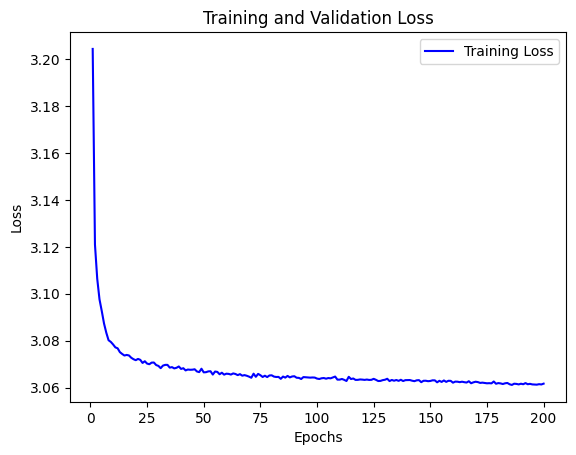

In [207]:
# Assuming you have a history object named 'history'

# Get the training and validation loss values from the history object
training_loss = history.history['loss']

# Get the number of epochs
epochs = range(1, len(training_loss) + 1)

# Plot the training and validation loss
plt.plot(epochs, training_loss, 'b-', label='Training Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Training and Validation Loss')
plt.legend()
plt.show()


In [208]:
pred = model.predict(X_train)

512/512 [==============================] - 1s 1ms/step


In [209]:
pred

array([[2.4850678],
       [2.129628 ],
       [0.       ],
       ...,
       [1.0230097],
       [0.       ],
       [1.027546 ]], dtype=float32)

In [210]:
mean_absolute_error(pred, y_train)

3.059458390264254

In [211]:
pred = model.predict(X_test)

110/110 [==============================] - 0s 1ms/step


In [214]:
mean_absolute_error(pred, y_test)

2.8649957277129023

In [213]:
pred = np.round(pred)
pred

array([[1.],
       [0.],
       [1.],
       ...,
       [1.],
       [1.],
       [0.]], dtype=float32)

In [155]:
rf_model = RandomForestRegressor()
rf_model.fit(X_train, y_train)

RandomForestRegressor()

In [156]:
pred = rf_model.predict(X_train)
mean_absolute_error(pred, y_train)

2.6269146890137467

In [157]:
pred = rf_model.predict(X_test)
mean_absolute_error(pred, y_test)

3.8212440315159735

In [112]:
df_encoded['fatalities'].describe()

count    23406.000000
mean         3.260446
std         12.763426
min          0.000000
25%          0.000000
50%          0.000000
75%          2.000000
max        400.000000
Name: fatalities, dtype: float64

In [203]:
# Get the feature importances
importances = rf_model.feature_importances_

# Get the indices that would sort the importances array in descending order
sorted_indices = np.argsort(importances)[::-1]

# Get the feature names
feature_names = X_train.columns

# Sort the feature names based on the sorted indices
sorted_features = feature_names[sorted_indices]

X_train = X_train[sorted_features[0:200]]
X_test = X_test[sorted_features[0:200]]